# Causal Attention 

**Author: Abraham R.**

The following notebook is an example of a vanilla attention head implementation.

Supports KV cache.


In [1]:
from dataclasses import dataclass
from typing import Optional
import torch
from torch import nn, Tensor
import torch.nn.functional as F
import matplotlib.pyplot as plt

@dataclass
class ModelArgs:
    dim: int = 128               # Model embedding dimension
    n_heads: int = 4             # Number of heads
    head_dim: int = 32           # dim // n_heads
    bias: bool = True           # FFN/MLP bias
    dropout: float = 0.1
    block_size: int = 128       

# Vanilla Attention

In [2]:
class AttentionHead(nn.Module):
    """
    Attention Head, implements the scaled dot-product attention to be used on the Multi-Head
    Attention.
    """
    def __init__(self,  args: ModelArgs) -> None:

        super().__init__()
        self.head_dim = args.head_dim
        self.key_query_value = nn.Linear(args.dim, 3 * args.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))


    def forward(self, x : Tensor, kv_cache : Optional[Tensor] = None, return_weights=False):
        _, T, C = x.shape
        key_query_value = self.key_query_value(x)
        k, q, v = torch.split(key_query_value, self.head_dim, dim=-1)

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

        weights = q @ k.transpose(-2, -1) * C**-0.5
        weights = weights.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        weights = F.softmax(weights, dim=-1) 

        out = weights @ v

        if return_weights:
            return out, weights

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

In [3]:
args = ModelArgs()
attention = AttentionHead(args)

batch_size = 2
seq_length = 10
x = torch.randn(batch_size, seq_length, args.dim)

output, new_kv_cache = attention(x, kv_cache=None)
print("Output shape:", output.shape)  # (batch_size, seq_length, head_dim)

Output shape: torch.Size([2, 10, 32])


## Visualizing single attention head

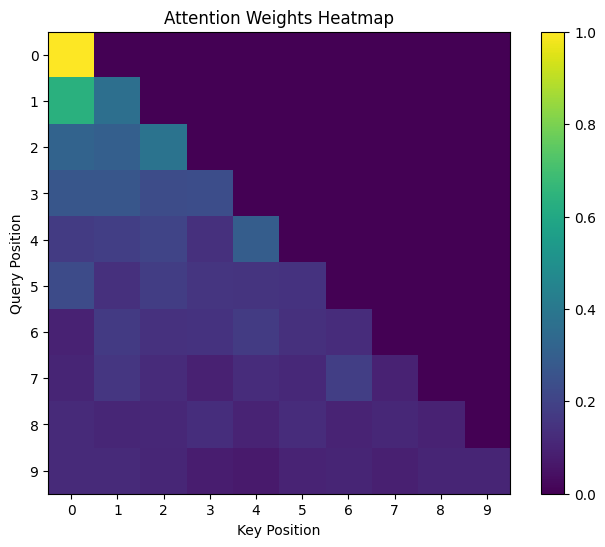

In [4]:
# Create input
batch_size = 1
seq_length = 10
x = torch.randn(batch_size, seq_length, args.dim)

# Run forward with weights
output, weights = attention(x, return_weights=True)

# weights shape: (batch_size, seq_length, seq_length)
weights = weights.detach().squeeze(0)  # (seq_length, seq_length)

plt.figure(figsize=(8, 6))
plt.imshow(weights.cpu(), cmap='viridis')
plt.colorbar()
plt.title('Attention Weights Heatmap')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.xticks(range(seq_length))
plt.yticks(range(seq_length))
plt.show()


# Multihead Attention

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args):
        super().__init__()
        assert args.dim % args.n_heads == 0, "Embedding dim must be divisible by number of heads"
        
        self.n_heads = args.n_heads
        self.head_dim = args.head_dim

        self.heads = nn.ModuleList([AttentionHead(args) for _ in range(self.n_heads)])
        self.proj = nn.Linear(args.n_heads * args.head_dim, args.dim)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []

        for head in self.heads:
            out, weights = head(x, kv_cache=kv_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights)

        concat = torch.cat(all_outputs, dim=-1)  # Concatenate over feature dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            # Shape: (n_heads, batch_size, seq_len, seq_len)
            return out, torch.stack(all_weights)

        return out


## Visualzing multiple attention heads

Using random input given the sequence, multiple "opinions" from each attention head can be visualized, emulating a pretrained model which performs similarly.

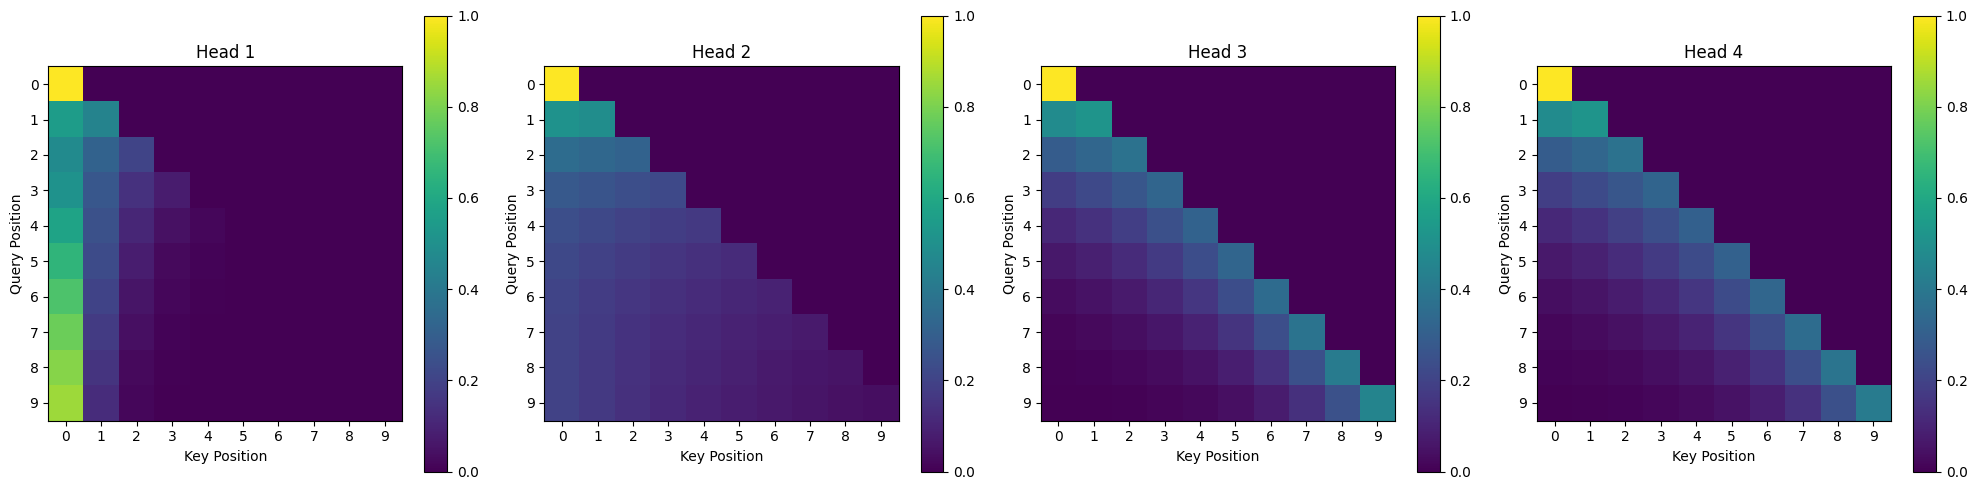

In [6]:
# Setup
args = ModelArgs()
mha = MultiHeadAttention(args)

# Input
batch_size = 1
seq_len = 10

x = torch.arange(seq_len).unsqueeze(0).repeat(batch_size, 1)  # Shape (batch, seq_len)
x = x.unsqueeze(-1).float()  # Shape (batch, seq_len, 1)
x = x.repeat(1, 1, args.dim)  # Broadcast to match (batch, seq_len, dim)

# Forward with weights
output, weights = mha(x, return_weights=True)

# weights shape: (n_heads, batch_size, seq_len, seq_len)
weights = weights.squeeze(1)  # -> (n_heads, seq_len, seq_len)

# Plot each head
fig, axes = plt.subplots(1, args.n_heads, figsize=(5 * args.n_heads, 5))

if args.n_heads == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    im = ax.imshow(weights[i].detach().cpu(), cmap='viridis')
    ax.set_title(f'Head {i+1}')
    ax.set_xlabel('Key Position')
    ax.set_ylabel('Query Position')
    ax.set_xticks(range(seq_len))
    ax.set_yticks(range(seq_len))
    fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()
